In [1]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.preprocessing import Imputer
from sklearn.pipeline import Pipeline
from catboost import CatBoostClassifier
from scipy.fftpack import fft, ifft
from lightkurve.lightcurve import LightCurve
import numpy as np

In [3]:
meta_data = pd.read_csv('../training_set_metadata.csv')

In [3]:
flux_data = pd.read_csv('../training_set.csv')
flux_data['detected'] = flux_data['detected'].astype(bool)
flux_data['mjd'] = pd.to_datetime((flux_data['mjd']-40587)*86400,unit='s')

### Смотрим графики говно

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f48160d7be0>,
      dtype=object)

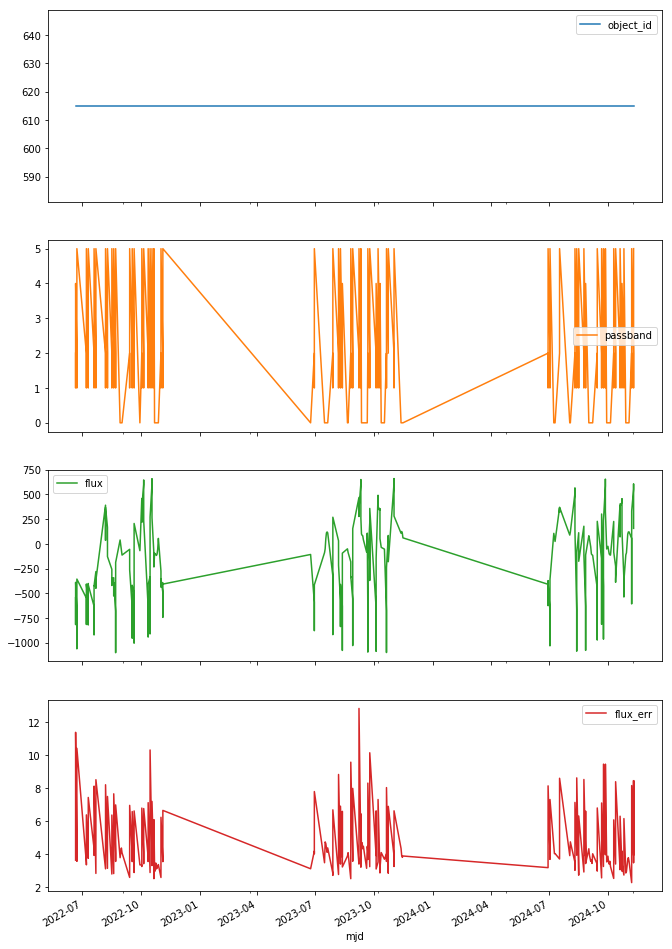

In [4]:
flux_data[(flux_data['object_id']==615)&(flux_data['detected']==True)].plot(figsize=(11,18), x='mjd',subplots=True)

In [5]:
passbender_dict = pd.DataFrame({
    'name':['u', 'g', 'r', 'i', 'z', 'Y'],
    'id':list(range(0,6))
})

In [6]:
def count_cdpp_for(df: pd.DataFrame) -> pd.DataFrame:
    '''
    Функция принимает датасет для конкретной пары фассбендер-обьект
    '''
    obj_passband, df = df
    pass_obj_flux =  df[(df['detected']==True)][['mjd','flux','flux_err']]
    lc = LightCurve(time=df['mjd'].astype(int),time_format='unix',flux=df['flux'],flux_err=df['flux_err'])
    return (obj_passband[0], obj_passband[1], lc.estimate_cdpp())

In [7]:
from multiprocessing import Pool

In [8]:
def count_passbenders(df: pd.DataFrame) -> pd.DataFrame:
    'Функция для подсчета всех фассбендеров для всех обьектов'
    res = map(count_cdpp_for,df.groupby(['object_id','passband']))
    return res

In [9]:
def create_good_tables(passbender_table: pd.DataFrame) -> pd.DataFrame:
    '''
    Принимает таблицу и приводит ее к широкому виду и названия красивые делает
    '''
    res = passbender_table.rename(columns={0:'cddp'}).reset_index().pivot(index='object_id',columns='passband',values='cddp')
    res.columns = res.columns.astype(str)
    res.columns = 'cddp_'+res.columns
    return res

In [10]:
passbender_cddp = count_passbenders(flux_data)

In [12]:
'''
Этот кусок стал выделять в отдельную функцию.
Просто преобразовывает результаты расчета флексов в датафрейм, переименует его и приводит к широкому виду
'''

passbender_cddp = create_good_tables(pd.DataFrame(list(passbender_cddp)).rename(columns={
    0: 'object_id',
    1: 'passband',
    2: 'cddp'
})).reset_index()

/home/cheburum/.local/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/cheburum/.local/lib/python3.6/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/cheburum/.local/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/cheburum/.local/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/cheburum/.local/lib/python3.6/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/cheburum/.local/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_s

In [17]:
'''
Добавляем посчитанные характеристики в мета-дату
'''

meta_data = meta_data.merge(passbender_cddp, on='object_id')

### Удаляем левые признаки и готовим данные для катбуста

In [9]:
train_features = list(meta_data.columns)
train_features.remove('target')
train_features.remove('object_id')
cat_features = [train_features.index('ddf')]

### Пишем пайплайн( Импутер заменяет наны на среднее в этом столбце)

In [10]:
estimator = Pipeline([("imputer", Imputer(strategy="mean",
                                          axis=0)),
                      ("catboost", CatBoostClassifier(loss_function='MultiClass',logging_level='Verbose', cat_features=cat_features))])

/home/cheburum/.local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


### Обучаем капуста

In [11]:
cross_val_results = cross_val_score(estimator, meta_data[train_features], meta_data['target'], scoring='neg_log_loss',n_jobs=-1)

/home/cheburum/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/home/cheburum/.local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
/home/cheburum/.local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
/home/cheburum/.local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer

-1.3759241517661271

In [ ]:
cross_val_results.mean()